# Ping pong result simulator
#### Author: Magnus Kvåle Helliesen

Playing ping pong, it seems that the result 9-6 or 6-9 pops up unreasonably often. This notebook simulates ping pong matches to see how often it "should" in fact pop up.

In [37]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import PowerNorm

%matplotlib inline  

## Functions for a single exhange, a game, and a bunch of games
We make a funciton that returns a simulated result from a single exchange between two players, *player 0* and *player 1*.
Each player has a skill $s$, and we let $s_0=\frac{p_0}{1-p_0}$, where $p_0=P(\textrm{player 0 won})$.
In other words, if $s_0=1$ then player 0 is equally good as player 1; if $s_0=2$ then player 0 is twice as good as player 1 etc. (It follows that $s_1=\frac{1}{s_0}$.)
Re-writing in terms of propabilities, we have that $p_0 = \frac{s_0}{s_0+1}$.
The simulation is performed using a uniformily distributet variable $x\sim U(0,1)$, and player 0 is said to have won if $x\leq p_0$. The function returns a pair of values: *person 0 won*, *person 1 won* (i.e. a pair of boolean values).

In [38]:
def result_from_single_exchange(s0):
    random_uniform = random.uniform(0,1)
    return (random_uniform <= s0/(s0+1)), (random_uniform > s0/(s0+1))

Next, we make a function that simulates a whole game, that is a sequence of exchanges until the criteriea for having won the game are met (the highest score is at least 11, and the difference in scores is at least 2). The function returns a list of all the scores of the game, that is a list of tuples of *(points player 0, points player 1)*.

In [39]:
def result_from_game(s0):
    scores_in_game = [(0, 0)]
    while (max(scores_in_game[-1][0], scores_in_game[-1][1]) < 11) or (abs(scores_in_game[-1][0]-scores_in_game[-1][1]) < 2):
        player0_won, player1_won = result_from_single_exchange(s0)
        scores_in_game.append((scores_in_game[-1][0]+player0_won, scores_in_game[-1][1]+player1_won))
    return scores_in_game

Lets look at an example game between two equally good players, i.e. $s_0 = 1$.

In [40]:
# An example game between equally good players
example_game = result_from_game(1)

In [41]:
# All scores of the game
print(*example_game)

(0, 0) (1, 0) (1, 1) (2, 1) (2, 2) (2, 3) (3, 3) (4, 3) (5, 3) (6, 3) (6, 4) (6, 5) (6, 6) (6, 7) (7, 7) (8, 7) (9, 7) (10, 7) (10, 8) (11, 8)


In [42]:
# The game ended with the score
example_game[-1]

(11, 8)

We generate a function that simulates $n$ games and stores all the results to a list. (We will be able to distinguish between games later because every game starts with 0-0.)

In [43]:
def game_simulator(s0, n, seed):
    random.seed(seed)
    simulation_of_games = []
    for i in range(n):
        simulation_of_games.extend(result_from_game(s0))
    return simulation_of_games

## Results for simulation of games between equal players
We now simulate 100,000 games between equaly skilled players and store it to a list. We then put it in a DataFrame, manipulate it, and plot it as a heatmap. We see that scores along the diagonal (that is, farily even matches) are the most frequent. Nevertheless, every so often a player wins 11 to nothing, and sometimes the game goes on until 25 points and more. Note that the heatmap uses a power-transformation, that is count is raised to the 1/4th power to make the plot a bit more busy. The reason is that otherwise 0-0 dominats the plot as it occurs every game.

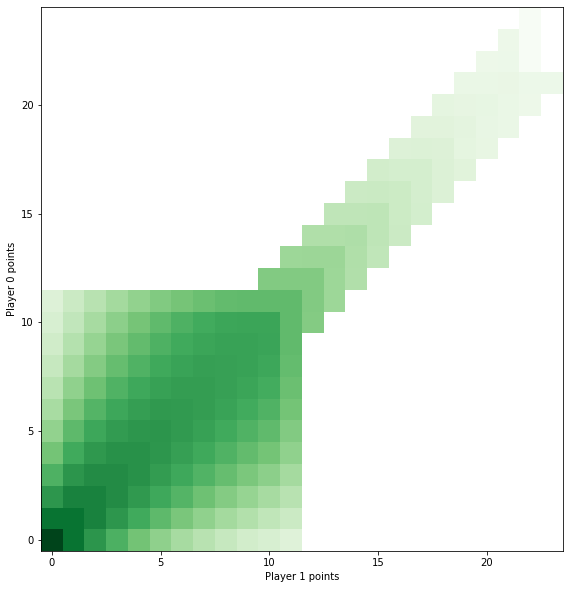

In [44]:
simulation_of_games = game_simulator(1, 100000, 1234)

df = pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])

df_to_plot = (
    pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])
    .assign(**{'': 1})
    .groupby(['player0_points', 'player1_points'])
    .count()
    .reset_index()
    .pivot_table(index=['player0_points'], columns=['player1_points'])
)

plt.figure(figsize=(10,10))
plt.imshow(df_to_plot, origin='lower', cmap ="Greens", norm=PowerNorm(0.25))
plt.ylabel('Player 0 points')
plt.xlabel('Player 1 points')
plt.show()

We also calculate the simulated probability of having the score result 9-6 or 6-9 in any given match. We see that it's about 30 %.

In [45]:
df = df.assign(**{'new_match': lambda df: [1 if (p1, p2) == (0, 0) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
df = df.assign(**{'match_id': lambda df: df['new_match'].cumsum()})
df = df.assign(**{'96/69': lambda df: [1 if (p1, p2) in ((9, 6), (6, 9)) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
df.groupby(df['match_id'])['96/69'].sum().mean()

0.30518

## Plots of scores for differen $s_0$
We now make a function that makes neat subplots for different relative skill levels.

In [46]:
def result_creator(n, seed):
    fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15, 17.5))
    #fig.tight_layout(pad=1.0)
    fig.supylabel('Player 0 points')
    fig.supxlabel('Player 1 points')
    fig.suptitle('Heatmap of scores for different skill levels of player 0, $s_0$')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    prob = []
    i, j = 0, 0
    for s0 in [1.2**i for i in range(-12,13)]:
        simulation_of_games = game_simulator(s0, n, 1234)

        df = pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])

        df_to_plot = (
            pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])
            .assign(**{'': 1})
            .groupby(['player0_points', 'player1_points'])
            .count()
            .reset_index()
            .pivot_table(index=['player0_points'], columns=['player1_points'])
        )

        ax[j ,i].imshow(df_to_plot, origin='lower',cmap ="Greens", norm=PowerNorm(0.25))
        ax[j ,i].title.set_text(''.join(['$s_0$=','{0:.2f}'.format(s0), ' ($p_0=' , '{0:.2f}'.format(s0/(s0+1)), ')']))
        ax[j ,i].set_xlim((0, 20))
        ax[j ,i].set_ylim((0, 20))
        ax[j ,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        ax[j ,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        df = df.assign(**{'new_match': lambda df: [1 if (p1, p2) == (0, 0) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
        df = df.assign(**{'match_id': lambda df: df['new_match'].cumsum()})
        df = df.assign(**{'96/69': lambda df: [1 if (p1, p2) in ((9, 6), (6, 9)) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
        prob.append(df.groupby(df['match_id'])['96/69'].sum().mean())
        
        if i == 4:
            i = 0
            j += 1
        else:
            i += 1

    plt.figure(figsize=(10, 10))
    plt.plot([2**i/(2**i+1) for i in range(-12,13)], prob, color='Red', linewidth=3)
    plt.title('Simulated density of score 9-6 and 6-9 for different values of $p_0$')
    plt.show()

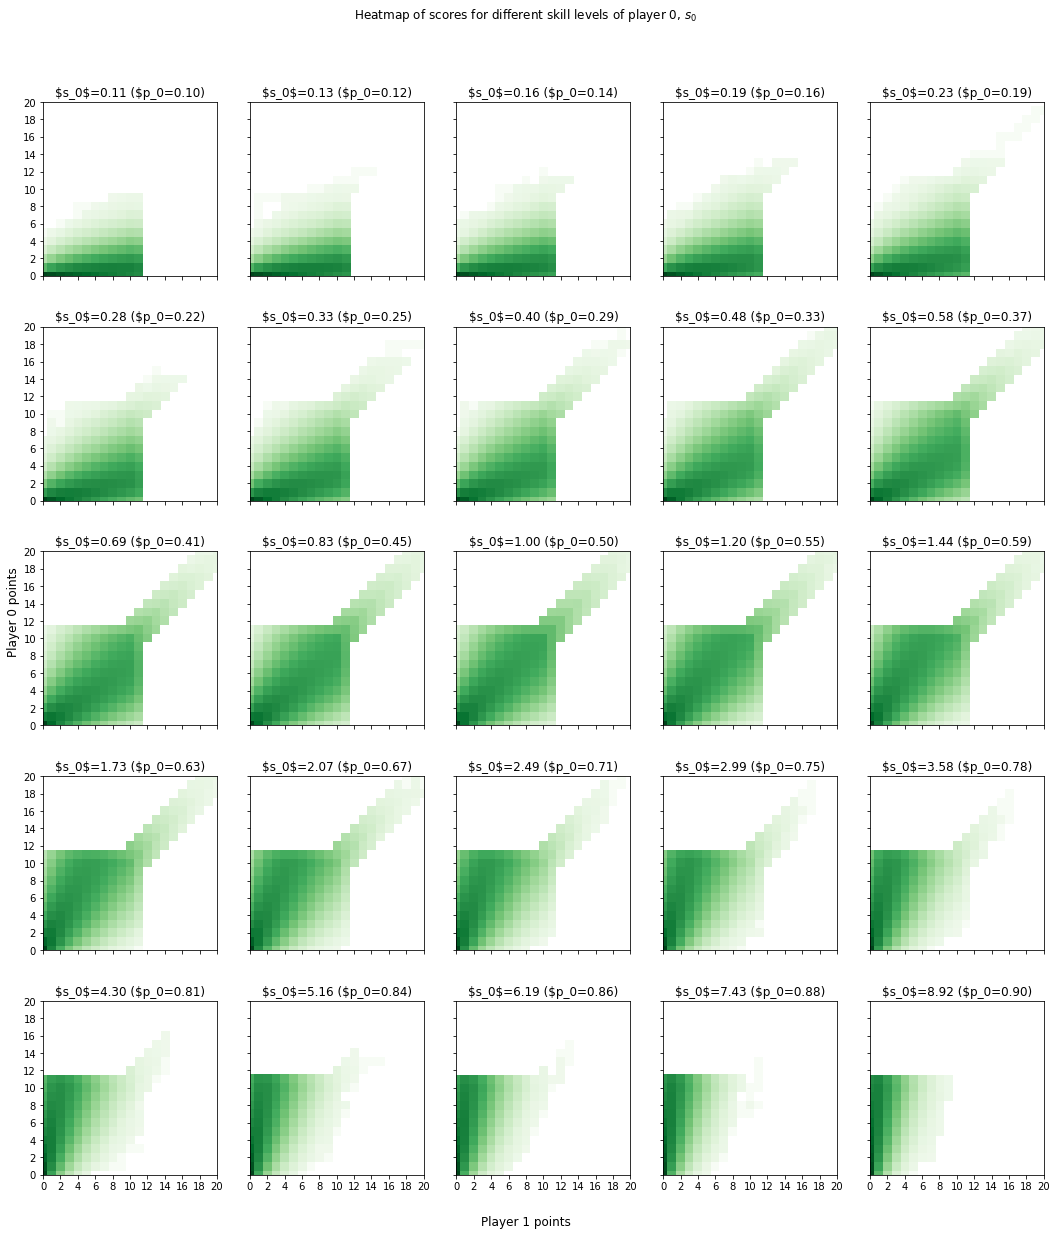

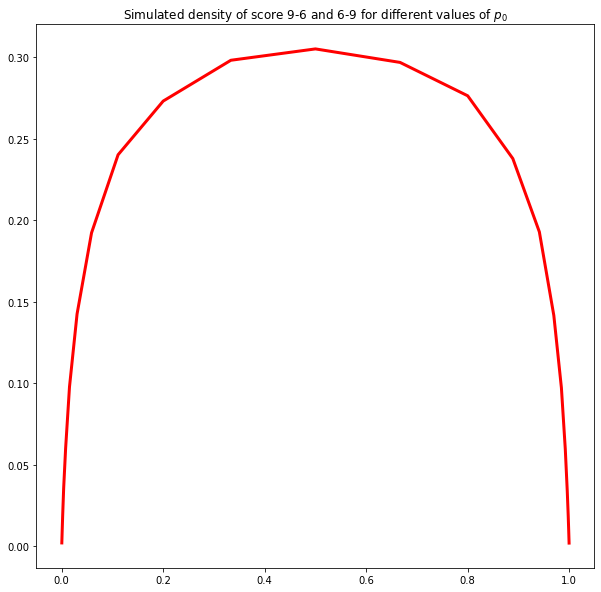

In [47]:
result_creator(100000, 1234)